In [1]:
!pip install -U albumentations>=0.3.0 
!pip install -U segmentation-models
!pip install tensorflow==2.2.1
!pip install keras==2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirem

In [2]:
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
import keras
import albumentations as A
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt

Segmentation Models: using `tf.keras` framework.


In [3]:
DATA_DIR = "./data/CamVid/"

if not os.path.exists(DATA_DIR):
  print("Loading Data...")
  os.system("git clone https://github.com/alexgkendall/SegNet-Tutorial ./data")
  print("Done!")

Loading Data...
Done!


In [4]:
x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "trainannot")

x_valid_dir = os.path.join(DATA_DIR, "val")
y_valid_dir = os.path.join(DATA_DIR, "valannot")

x_test_dir = os.path.join(DATA_DIR, "test")
y_test_dir = os.path.join(DATA_DIR, "testannot")

In [5]:
def visualize(**images):
  n = len(images)
  plt.figure(figsize=(16, 5))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(" ".join(name.split("_")).title())
    plt.imshow(image)
  plt.show()

In [6]:
def denormalize(x):
  x_max = np.percentile(x, 98)
  x_min = np.percentile(x, 2)
  x = (x - x_min) / (x_max - x_min)
  x = x.clip(0, 1)
  return x

In [7]:
class Dataset:
  CLASSES = [
      "sky", "building", "pole", "road",
      "pavement", "tree", "signsymbol", 
      "fence", "car", "pedestrian", 
      "bicyclist", "unlabelled"
  ]

  def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
    self.ids = os.listdir(images_dir)
    self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
    self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
    self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    self.augmentation = augmentation
    self.preprocessing = preprocessing
  
  def __getitem__(self, i):
    image = cv2.imread(self.images_fps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], 0)

    masks = [(mask == v) for v in self.class_values]
    mask = np.stack(masks, axis=-1).astype("float")

    if mask.shape[-1] != 1:
      background = 1 - mask.sum(axis=-1, keepdims=True)
      mask = np.concatenate((mask, background), axis=-1)
    
    if self.augmentation:
      sample = self.augmentation(image=image, mask=mask)
      image, mask = sample["image"], sample["mask"]

    return image, mask

  def __len__(self):
    return len(self.ids)

In [8]:
class DataLoader(keras.utils.Sequence):
  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(len(dataset))
    self.on_epoch_end()

  def __getitem__(self, i):
    start = i * self.batch_size
    stop = (i + 1) * self.batch_size
    data = []
    for j in range(start, stop):
      data.append(self.dataset[j])
    batch = [np.stack(samples, axis=0) for samples in zip(*data)]
    return batch

  def __len__(self):
    return len(self.indexes) // self.batch_size
  
  def on_epoch_end(self):
    if self.shuffle:
      self.indexes = np.random.permutation(self.indexes)

In [9]:
dataset = Dataset(x_train_dir, y_train_dir, classes=["car", "pedestrian"])

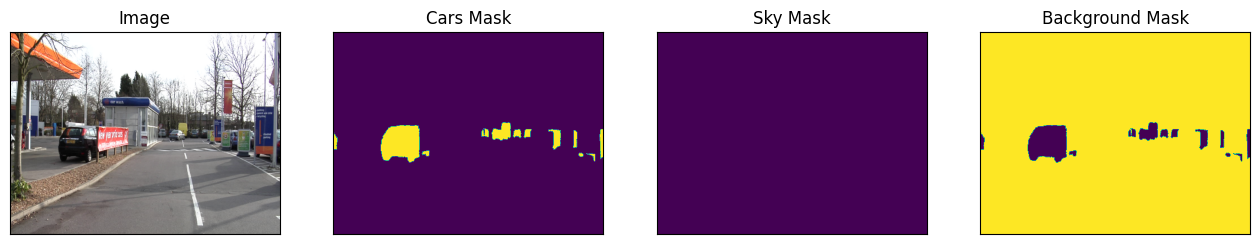

In [10]:
image, mask = dataset[5]
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze()
)

In [11]:
def round_clip_0_1(x, **kwargs):
  return x.round().clip(0, 1)

In [12]:
def get_training_augmentation():
  train_transform = [
      A.HorizontalFlip(p=0.5),
      A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
      A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
      A.RandomCrop(height=320, width=320, always_apply=True),
      A.IAAAdditiveGaussianNoise(p=0.2),
      A.IAAPerspective(p=0.5),
      A.OneOf([
          A.CLAHE(p=1),
          A.RandomBrightness(p=1),
          A.RandomGamma(p=1)
      ], p=0.9),
      A.OneOf([
          A.IAASharpen(p=1),
          A.Blur(blur_limit=3, p=1),
          A.MotionBlur(blur_limit=3, p=1)
      ], p=0.9),
      A.OneOf([
          A.RandomContrast(p=1),
          A.HueSaturationValue(p=1),
      ], p=0.9),
      A.Lambda(mask=round_clip_0_1)
  ]
  return A.Compose(train_transform)

In [13]:
def get_validation_augmentation():
  test_transform = [
      A.PadIfNeeded(384, 480)
  ]
  return A.Compose(test_transform)

In [14]:
def get_preprocessing(preprocessing_fn):
  _transform = [
      A.Lambda(image=preprocessing_fn)
  ]
  return A.Compose(_transform)

/usr/local/lib/python3.9/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.9/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.9/dist-packages/albument

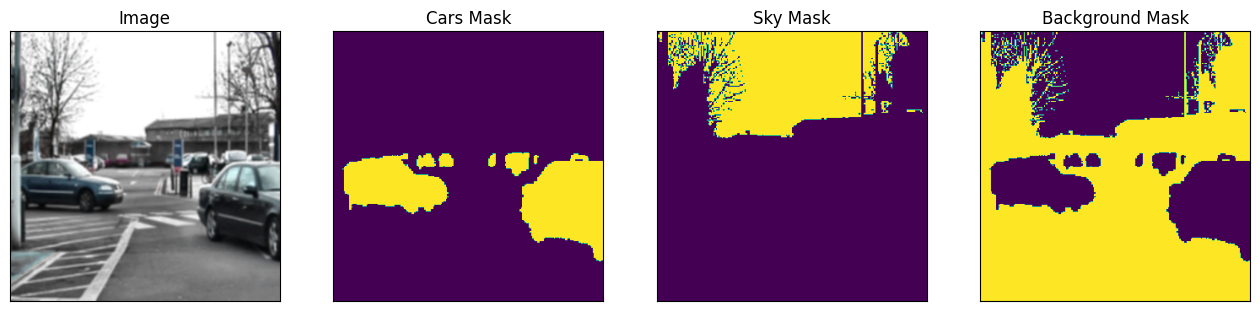

In [15]:
dataset = Dataset(x_train_dir, y_train_dir, classes=["car", "sky"], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

In [16]:
BACKBONE = "efficientnetb3"
BATCH_SIZE = 8
CLASSES = ["car", "pedestrian"]
LR = 0.0001
EPOCHS = 40

In [17]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [18]:
n_classes = 1 if len(CLASSES) == 1 else len(CLASSES) + 1

In [19]:
activation = "sigmoid" if n_classes == 1 else "softmax"

In [20]:
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44107200/44107200 [==============================] - 1s 0us/step


In [21]:
optim = keras.optimizers.Adam(LR)

In [22]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5]))
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + (1 * focal_loss)

In [23]:
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5)
]

In [24]:
model.compile(optim, total_loss, metrics)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_1[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                           

In [26]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "./best_model.h5",
        save_weights_only=True,
        save_best_only=True,
        mode="min"
    ),
    keras.callbacks.ReduceLROnPlateau()
]

In [29]:
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader)
)

Epoch 1/40
45/45 [==============================] - 57s 599ms/step - loss: 0.8948 - iou_score: 0.1338 - f1-score: 0.2108 - val_loss: 1.3055 - val_iou_score: 0.0638 - val_f1-score: 0.1136 - lr: 1.0000e-04
Epoch 2/40
45/45 [==============================] - 22s 495ms/step - loss: 0.7772 - iou_score: 0.3699 - f1-score: 0.4705 - val_loss: 0.9701 - val_iou_score: 0.1933 - val_f1-score: 0.2771 - lr: 1.0000e-04
Epoch 3/40
45/45 [==============================] - 21s 462ms/step - loss: 0.7045 - iou_score: 0.5185 - f1-score: 0.5889 - val_loss: 0.8370 - val_iou_score: 0.3489 - val_f1-score: 0.4390 - lr: 1.0000e-04
Epoch 4/40
45/45 [==============================] - 22s 475ms/step - loss: 0.6442 - iou_score: 0.5586 - f1-score: 0.6206 - val_loss: 0.7670 - val_iou_score: 0.5833 - val_f1-score: 0.6565 - lr: 1.0000e-04
Epoch 5/40
45/45 [==============================] - 22s 479ms/step - loss: 0.6132 - iou_score: 0.5646 - f1-score: 0.6268 - val_loss: 0.7157 - val_iou_score: 0.5962 - val_f1-score: 0.66

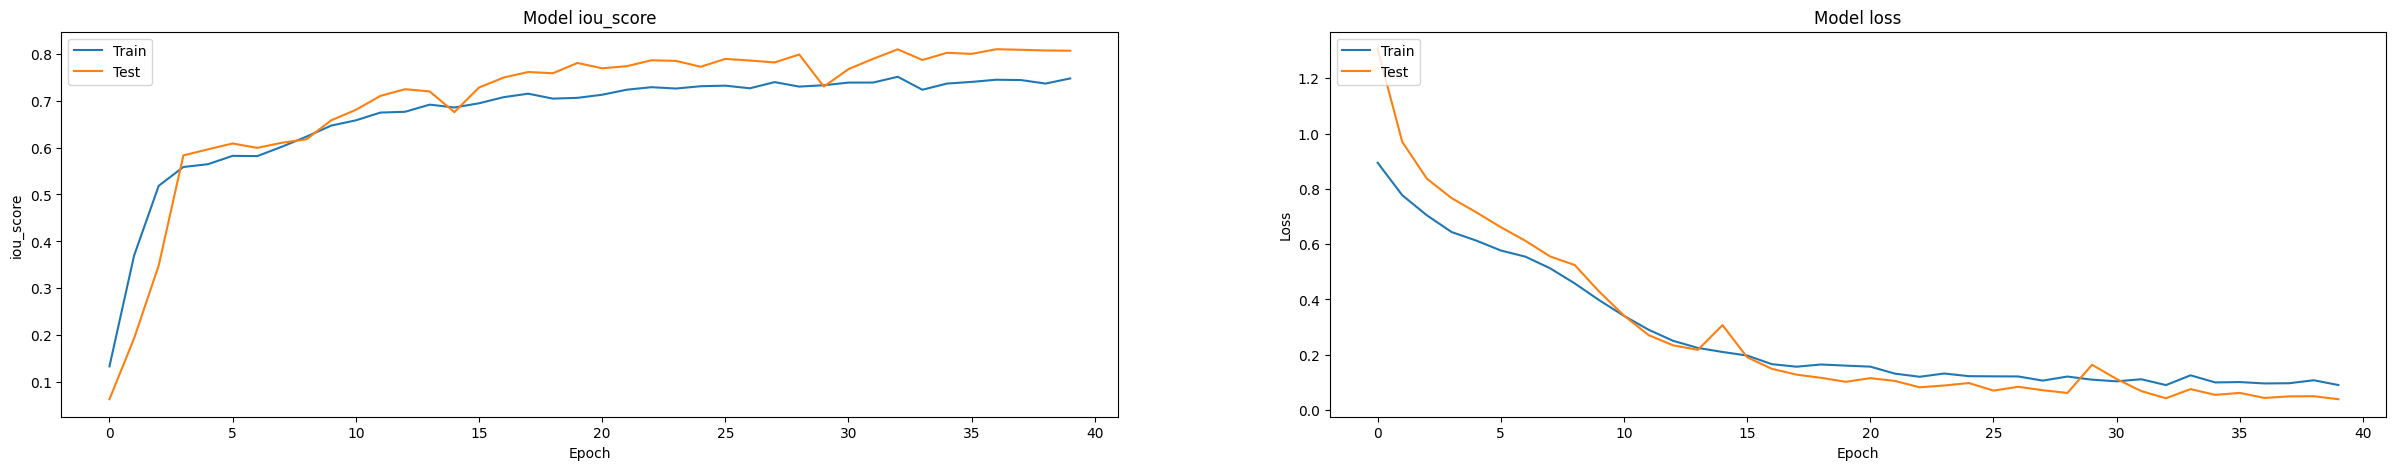

In [30]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history["iou_score"])
plt.plot(history.history["val_iou_score"])
plt.title("Model iou_score")
plt.ylabel("iou_score")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [31]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [32]:
model.load_weights("best_model.h5") 

In [33]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

233/233 [==============================] - 9s 32ms/step - loss: 0.2085 - iou_score: 0.7266 - f1-score: 0.7972
Loss: 0.20852
mean iou_score: 0.72665
mean f1-score: 0.79721


1/1 [==============================] - 2s 2s/step


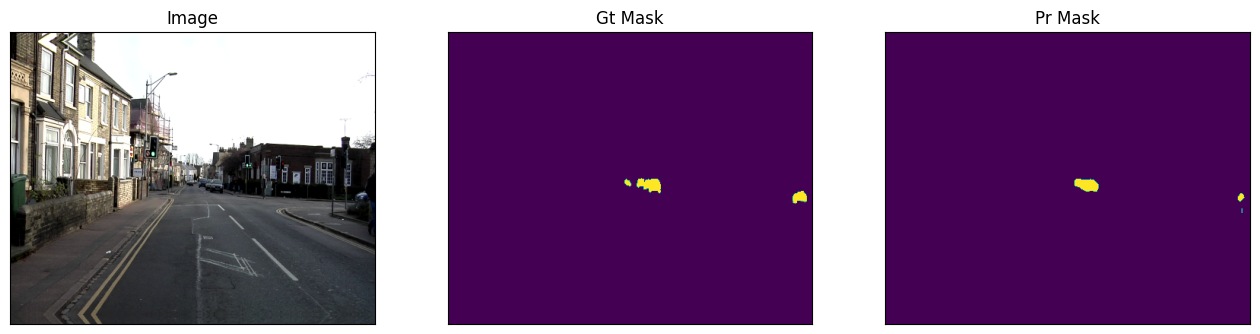

1/1 [==============================] - 0s 29ms/step


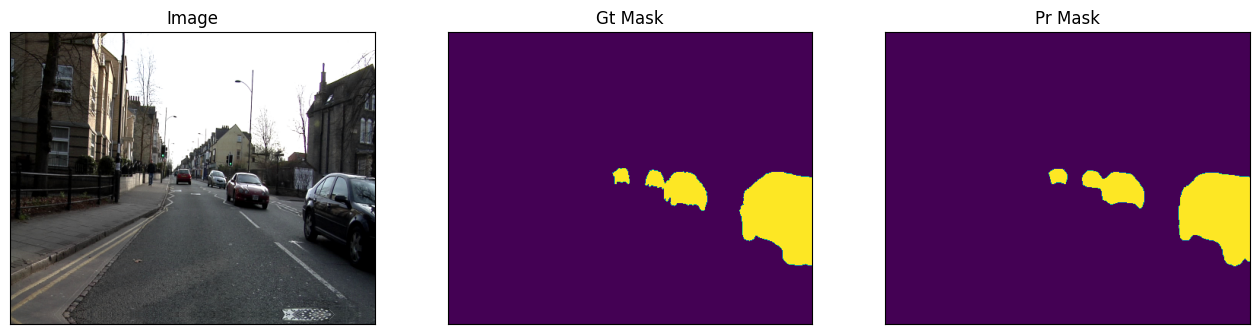

1/1 [==============================] - 0s 29ms/step


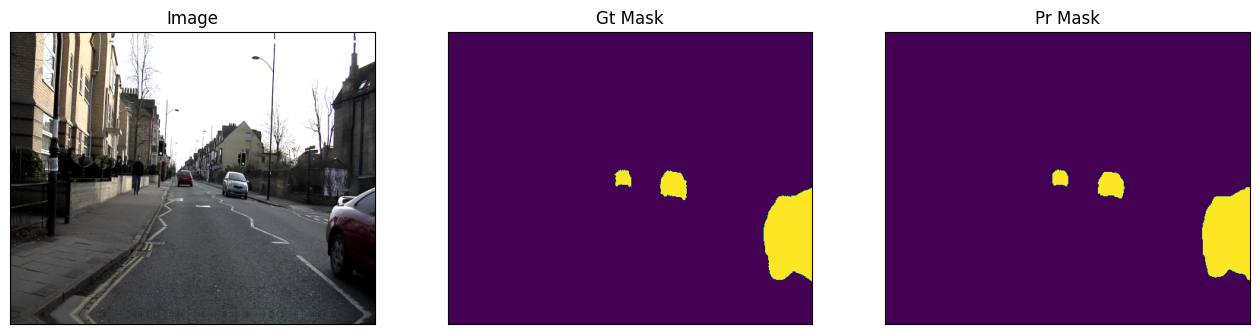

1/1 [==============================] - 0s 32ms/step


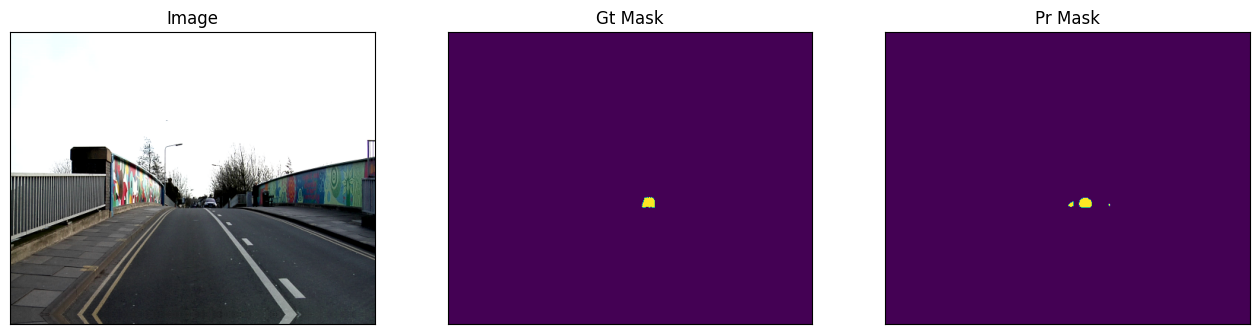

1/1 [==============================] - 0s 46ms/step


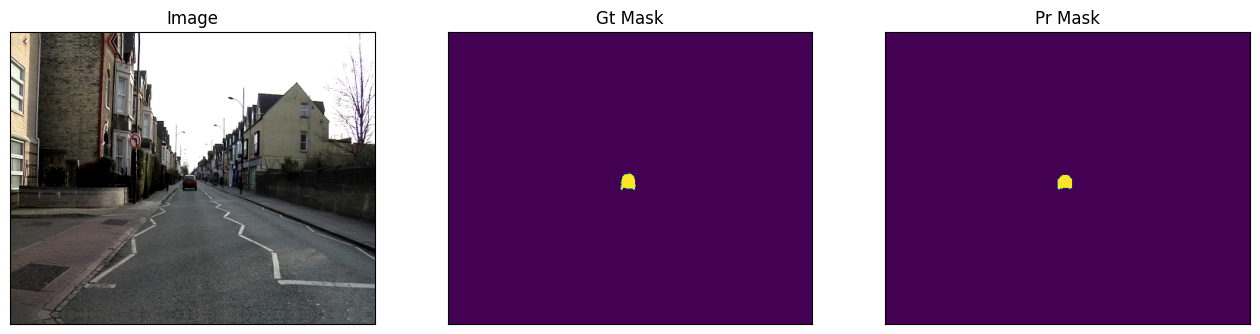

In [34]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )